# Import packages

In [ ]:
import os
import random
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout, Reshape,  \
                              GlobalAveragePooling2D, AveragePooling2D, Input, Concatenate, Layer, Average, MaxPool2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from tensorflow.keras.utils import Sequence

import itertools
from PIL import Image
import torch
import torchvision.transforms as transforms
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy import stats, special
import matplotlib.pyplot as plt

# GPU 확인

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

2022-05-29 04:00:41.028391: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 04:00:41.030066: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 04:00:41.031027: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 04:00:41.045328: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

1 Physical GPUs, 1 Logical GPUs


ysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 04:00:46.156121: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 04:00:46.156727: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15045 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [ ]:
!nvidia-smi

Sun May 29 04:00:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    32W / 250W |    735MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 데이터 준비

In [ ]:
!tar xzvf ../input/challenges-in-representation-learning-facial-expression-recognition-challenge/fer2013.tar.gz
%mkdir ./models

fer2013/fer2013.csv
fer2013/README
fer2013/fer2013.bib
fer2013/


In [ ]:
DATA_PATH = "./fer2013/fer2013.csv"

# 사전 설정

## mixed precision

In [ ]:
# 효율적인 GPU 사용을 위한 mixed precision 설정
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

2022-05-29 04:00:52.850122: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Dataloader

In [ ]:
# 참조: https://minimin2.tistory.com/100
# 매 epoch 마다 data augmentation을 진행하기 위한 dataloader class

class Dataloader(Sequence):
    def __init__(self, x_set, y_set, transform=None, batch_size=64, shuffle=True):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.transform = transform # data augmentation 진행할 torchvision transform 모듈
        self.on_epoch_end()
    
    def img_preprocess(self, idx):
        img = np.array(self.x[idx])
        img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)
        label = np.array([self.y[idx]] * 10)
        return img, label

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    # 데이터를 batch size 만큼 불러오며 img_preprocess 통해 augmentation 한 데이터 반환
    def __getitem__(self, idx):
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_x_list, batch_y_list = map(list, zip(*[self.img_preprocess(i) for i in indices]))
        
        batch_x = np.array(batch_x_list)
        batch_y = np.array(batch_y_list)
        
        bs, ncrops, h, w, c = batch_x.shape
        batch_x = batch_x.reshape([-1, h, w, c])
        
        bs, ncrops, labels = batch_y.shape
        batch_y = batch_y.reshape([-1, labels])

        return batch_x, batch_y

    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

## load data

In [ ]:
# 참조: https://github.com/usef-kh/fer/blob/master/data/fer2013.py
def load_data(path=DATA_PATH):
    fer2013 = pd.read_csv(path)
    emotion_mapping = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

    return fer2013, emotion_mapping

# df에서 이미지와 label을 추출하여 array로 반환
def prepare_data(data):
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    onehot_encoder = OneHotEncoder()
    image_label = image_label.reshape(-1, 1)
    image_label = onehot_encoder.fit_transform(image_label)
    image_label = image_label.toarray()

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label


def get_dataloaders(path=DATA_PATH, bs=64, augment=True):
    fer2013, emotion_mapping = load_data(path)

    xtrain, ytrain = prepare_data(fer2013[fer2013['Usage'] == 'Training'])
    xval, yval = prepare_data(fer2013[fer2013['Usage'] == 'PrivateTest'])
    xtest, ytest = prepare_data(fer2013[fer2013['Usage'] == 'PublicTest'])

    mu, st = 0, 255

    test_transform = transforms.Compose([
        transforms.TenCrop(40),
        transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
        transforms.Lambda(lambda tensors: torch.stack([transforms.Normalize(mean=(mu,), std=(st,))(t) for t in tensors]).permute(0, 2, 3, 1).numpy()),
    ])

    if augment:
        train_transform = transforms.Compose([
            transforms.RandomResizedCrop(48, scale=(0.8, 1.2)), # randomly rescale
            transforms.RandomApply([transforms.RandomAffine(0, translate=(0.2, 0.2))], p=0.5), # randomly translate
            transforms.RandomHorizontalFlip(),# randomly horizontal flip
            transforms.RandomApply([transforms.RandomRotation(10)], p=0.5), # randomly rotate
            transforms.TenCrop(40), # ten-crop
            transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
            transforms.Lambda(lambda tensors: torch.stack([transforms.Normalize(mean=(mu,), std=(st,))(t) for t in tensors])), # normalize
            transforms.Lambda(lambda tensors: torch.stack([transforms.RandomErasing(p=0.5)(t) for t in tensors]).permute(0, 2, 3, 1).numpy()), # keras 모델의 입력인 (batch size, 40, 40, 1) input에 맞도록 reshape
        ])
    else:
        train_transform = test_transform

    trainloader = Dataloader(xtrain, ytrain, transform=train_transform, batch_size=128)
    valloader = Dataloader(xval, yval, transform=test_transform, batch_size=128)
    testloader = Dataloader(xtest, ytest, transform=test_transform, shuffle=False, batch_size=128)

    return trainloader, valloader, testloader

# 후에 정확도 측정 및 confusion matrix 생성을 위해 test 데이터 label만 불러오는 메서드
def get_test_labels():
    fer2013, emotion_mapping = load_data(DATA_PATH)
    x_test, y_test = prepare_data(fer2013[fer2013['Usage'] == 'PublicTest'])
    
    mu, st = 0, 255

    test_transform = transforms.Compose([
        transforms.TenCrop(40),
        transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
        transforms.Lambda(lambda tensors: torch.stack([transforms.Normalize(mean=(mu,), std=(st,))(t) for t in tensors]).permute(0, 2, 3, 1).numpy()),
    ])

    testloader_cm = Dataloader(x_test, y_test, batch_size=3589, transform=test_transform, shuffle=False)
    xtest, ytest = next(iter(testloader_cm))
    
    return emotion_mapping, np.argmax(ytest, axis=1) 

In [ ]:
trainloader, valloader, testloader = get_dataloaders(bs=128)

# models

In [ ]:
input_shape = (40, 40, 1)
model_input = Input(shape=input_shape)

## GoogLeNet

In [ ]:
## 참조 : https://github.com/hskang9/Googlenet/blob/master/keras/googlenet.py -- LRN 코드
## 참조 : https://sike6054.github.io/blog/paper/second-post/
class LRN2D(Layer):
    """
    This code is adapted from pylearn2.
    License at: https://github.com/lisa-lab/pylearn2/blob/master/LICENSE.txt
    """

    def __init__(self, alpha=0.0001,k=1,beta=0.75,n=3, name=None):
        if n % 2 == 0:
            raise NotImplementedError("LRN2D only works with odd n. n provided: " + str(n))
        super(LRN2D, self).__init__()
        self.alpha = alpha
        self.k = k
        self.beta = beta
        self.n = n
        self.test = name

    def get_output(self, train):
        X = self.get_input(train)
        return tf.nn.lrn(X)

    def get_config(self):
        return {"test": self.__class__.__name__,
                "alpha": self.alpha,
                "k": self.k,
                "beta": self.beta,
                "n": self.n}


def inception(input_tensor, filter_channels):
    filter_1x1, filter_3x3_Reduce, filter_5x5_Reduce, filter_5x5, pool_proj = filter_channels
    
    branch_1 = Conv2D(filter_1x1, kernel_size=(1, 1), padding='same', strides=(1, 1), activation='relu', kernel_initializer='he_normal')(input_tensor)
    branch_1 = BatchNormalization()(branch_1)
    
    branch_2 = Conv2D(filter_3x3_Reduce, kernel_size=(1, 1), padding='same', strides=(1, 1), activation='relu', kernel_initializer='he_normal')(input_tensor)
    branch_2 = BatchNormalization()(branch_2)

    branch_3 = Conv2D(filter_5x5_Reduce, kernel_size=(1, 1),  padding='same', strides=(1, 1), activation='relu', kernel_initializer='he_normal')(input_tensor)
    branch_3 = BatchNormalization()(branch_3)
    branch_3 = Conv2D(filter_5x5, kernel_size=(5, 5), padding='same', strides=(1, 1), activation='relu', kernel_initializer='he_normal')(branch_3)
    branch_3 = BatchNormalization()(branch_3)
    
    branch_4 = MaxPooling2D(pool_size=(3, 3), padding='same', strides=1)(input_tensor)
    branch_4 = Conv2D(pool_proj, kernel_size=(1, 1), padding='same', strides=(1, 1), activation='relu', kernel_initializer='he_normal')(branch_4)
    branch_4 = BatchNormalization()(branch_4)
    
    DepthConcat = Concatenate()([branch_1, branch_2, branch_3, branch_4])
    
    return DepthConcat



#논문에 맞게 CIPIIPIIPIIPF 구조로 GoogLeNet 변형
#Inception layer는 3x3 feature maps 기반, 7개의 inception 사용
#n값의 초기값은 32이고, 이후 inception layer마다 32씩 증가
#n값에 따라 1x1, 3x3 reduce, 5x5 reduce, 5x5, pool projection은 3/4n, 1/2n, 1/8n, 1/4n, 1/4n에 대응
def GoogLeNet(model_input, classes=7):
    conv_1 = Conv2D(192, kernel_size=(3, 3), padding='same', activation='relu')(model_input)
    conv_1_normalize = BatchNormalization()(conv_1)
    poo11_norm1 = LRN2D(name='pool1/norm1')(conv_1_normalize)

    #n=32, 3/4n, 1/2n, 1/8n, 1/4n, 1/4n에 따라 1x1, 3x3 reduce, 5x5 reduce, 5x5, pool projection 24, 16, 4, 8, 8 대응            
    inception_1a = inception(poo11_norm1, [24, 16, 4, 8, 8]) 
    pool_1 = MaxPooling2D(pool_size=(3, 3), padding='same', strides=2)(inception_1a) 
    
    #n=64, 3/4n, 1/2n, 1/8n, 1/4n, 1/4n에 따라 1x1, 3x3 reduce, 5x5 reduce, 5x5, pool projection 48, 32, 8, 16, 16 대응 
    inception_2a = inception(pool_1, [48, 32, 8, 16, 16])

    #n=96, 3/4n, 1/2n, 1/8n, 1/4n, 1/4n에 따라 1x1, 3x3 reduce, 5x5 reduce, 5x5, pool projection 72, 48, 12, 24, 24 대응  
    inception_2b = inception(inception_2a, [72, 48, 12, 24, 24]) 
    pool_2 = MaxPooling2D(pool_size=(3, 3), padding='same', strides=2)(inception_2b) 
    
    #n=128, 3/4n, 1/2n, 1/8n, 1/4n, 1/4n에 따라 1x1, 3x3 reduce, 5x5 reduce, 5x5, pool projection 96, 64, 16, 32, 32 대응
    inception_3a = inception(pool_2, [96, 64, 16, 32, 32]) 

    #n=160, 3/4n, 1/2n, 1/8n, 1/4n, 1/4n에 따라 1x1, 3x3 reduce, 5x5 reduce, 5x5, pool projection 120, 80, 20, 40, 40 대응
    inception_3b = inception(inception_3a, [120, 80, 20, 40, 40]) 
    pool_3 = MaxPooling2D(pool_size=(3, 3), padding='same', strides=(2, 2))(inception_3b) 

    #n=192, 3/4n, 1/2n, 1/8n, 1/4n, 1/4n에 따라 1x1, 3x3 reduce, 5x5 reduce, 5x5, pool projection 144, 96, 24, 48, 48 대응
    inception_4a = inception(pool_3, [144, 96, 24, 48, 48]) 
    
    #n=224, 3/4n, 1/2n, 1/8n, 1/4n, 1/4n에 따라 1x1, 3x3 reduce, 5x5 reduce, 5x5, pool projection 168, 112, 28, 56, 56 대응
    inception_4b = inception(inception_4a, [168, 112, 28, 56, 56]) 
    
    
    avg_pool = GlobalAveragePooling2D()(inception_4b)
    linear = Dense(1000, activation='relu')(avg_pool)
    dropout = Dropout(0.4)(linear)
    model_output = Dense(classes, activation='softmax', name='main_classifier')(dropout) 
    
    model = Model(model_input, model_output)
    
    return model


googlenet = GoogLeNet(model_input, 7)
# Stochastic Gradient Descent(확률적 경사 하강법) 이용
opt_googlenet = SGD(learning_rate=0.1, momentum=0.9, nesterov=True, decay=0.0001)

googlenet.compile(optimizer=opt_googlenet, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
googlenet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40, 40, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 40, 40, 192)  1920        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 40, 40, 192)  768         conv2d[0][0]                     
__________________________________________________________________________________________________
lr_n2d (LRN2D)                  (None, 40, 40, 192)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

## ResNet

In [ ]:
#참고 논문 : Deep Residual Learning for Image Recognition (https://arxiv.org/abs/1512.03385)
#코드 : 핸즈온 머신러닝 2판(책) 14장 5절

#Resnet34는 34개 층으로 이루어져있고, 64개의 특성 맵을 출력하는 3개의 Residual Unit, 128개의 특성 맵을 출력하는 4개의 Residual Unit, 512개의 특성 맵을 출력하는 3개의 Residual Unit을 포함한다
#먼저 Residual Unit층을 구현한다.
class Residual_Unit(keras.layers.Layer):
    def __init__(self, filters, strides = 1, activation = 'relu',**kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters,3,strides = strides,padding = "same",use_bias = False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters,3,strides = 1,padding = "same",use_bias = False),
            keras.layers.BatchNormalization()
        ]
        #main_layers는 convolution과 batch normalization을 사용하는 기본적인 구조다.
        self.skip_layers = []
        if strides > 1 :
            self.skip_layers = [
                keras.layers.Conv2D(filters,1,strides = strides,padding = "same",use_bias = False),
                keras.layers.BatchNormalization()
            ]
        #skip_layers는 convolution과 batch normalization을 stride가 1보다 큰 경우에만 적용한다. 즉, 입력과 출력의 크기가 다른 경우를 의미한다. 
        #입력과 출력의 크기가 다르면 입력이 Residual Unit의 출력에 바로 더해질 수 없다.

    def get_config(self):
      config = super().get_config().copy()
      config.update({
          'activation' : self.activation,
          'main_layers' : self.main_layers,
          'skip_layers' : self.skip_layers,
      })
      return config
            
    def call(self,inputs):
       x = inputs
       for layer in self.main_layers :
         x = layer(x)
         skip = inputs
       for layer in self.skip_layers:
         skip = layer(skip)
       return self.activation(x+skip)
    #call()은 input을 main layer와 skip layer에 통과시키고 두 출력을 더하여 activation function에 통과시킨다.

resnet = keras.models.Sequential()
#Residual Unit을 준비해두었기 때문에 Residual Unit을 하나의 층처럼 취급할 수 있다. 그러므로 Sequential class를 이용해 구현한다.
resnet.add(Input(shape=input_shape))

prev_filters = 32
for filters in [32]*3 + [64]*4 + [128]*6 + [256]*3 : 
    strides = 1 if filters == prev_filters else 2
    resnet.add(Residual_Unit(filters,strides = strides))
    prev_filters = filters
#64개의 특성 맵을 출력하는 3개의 Residual Unit, 128개의 특성 맵을 출력하는 4개의 Residual Unit, 512개의 특성 맵을 출력하는 3개의 Residual Unit을 for문을 이용해 구현해주었다.
#Filter 개수가 이전과 같으면 stride를 1, 아니면 2로 설정하고, filter개수를 계속 update해주었다.
resnet.add(keras.layers.GlobalAvgPool2D())
resnet.add(keras.layers.Flatten())
resnet.add(keras.layers.Dropout(0.4))
resnet.add(keras.layers.Dense(7,activation = "softmax")) 


# Stochastic Gradient Descent(확률적 경사 하강법) 이용
opt_resnet = SGD(learning_rate=0.01, momentum=0.9, nesterov=True, decay=0.0001)
# val loss를 모니터 하여 정체될 경우 lr 감소
lr_schedule = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.75,
    patience=5,
    verbose=True
)

resnet.compile(optimizer=opt_resnet, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
resnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
res__unit (Res_Unit)         (None, 40, 40, 32)        9760      
_________________________________________________________________
res__unit_1 (Res_Unit)       (None, 40, 40, 32)        18688     
_________________________________________________________________
res__unit_2 (Res_Unit)       (None, 40, 40, 32)        18688     
_________________________________________________________________
res__unit_3 (Res_Unit)       (None, 20, 20, 64)        58112     
_________________________________________________________________
res__unit_4 (Res_Unit)       (None, 20, 20, 64)        74240     
_________________________________________________________________
res__unit_5 (Res_Unit)       (None, 20, 20, 64)        74240     
_________________________________________________________________
res__unit_6 (Res_Unit)       (None, 20, 20, 64)        7

## VGGNet

In [ ]:
#참조 : https://bskyvision.com/504
#VGGNET을 논문에 맞게 BatchNormalization추가 및 변형 
#VGGNET은 ReLU 함수를 이용하고 네트워크의 깊이를 깊게 하고 parameter의 수를 적게하기 위해 모든 convolution layer에서의 kernel size는 3x3, stride는 1로 통일합니다. 
vggnet = Sequential()
vggnet.add(Conv2D(input_shape=input_shape, filters=64, kernel_size=(3,3), padding="same", activation="relu"))
vggnet.add(BatchNormalization())
vggnet.add(Conv2D(64, kernel_size=(3,3), padding="same", strides=(1,1), activation="relu")) #40x40x64의 feature map 생성
vggnet.add(BatchNormalization())
vggnet.add(MaxPool2D(pool_size=(2,2), padding="valid")) #20x20x64로 feature map size 감소 

vggnet.add(Conv2D(128, kernel_size=(3,3), padding="same", strides=(1,1), activation="relu")) #20x20x128의 feature map 생성
vggnet.add(BatchNormalization())
vggnet.add(Conv2D(128, kernel_size=(3,3), padding="same", strides=(1,1), activation="relu"))
vggnet.add(BatchNormalization())
vggnet.add(MaxPool2D(pool_size=(2,2), padding="valid")) #10x10x128로 feature map size 감소

vggnet.add(Conv2D(256, kernel_size=(3,3), padding="same", strides=(1,1), activation="relu")) #10x10x256의 feature map 생성
vggnet.add(BatchNormalization())
vggnet.add(Conv2D(256, kernel_size=(3,3), padding="same", strides=(1,1), activation="relu"))
vggnet.add(BatchNormalization())
vggnet.add(MaxPool2D(pool_size=(2,2), padding="valid"))  #5x5x256로 feature map size 감소 

vggnet.add(Conv2D(512, kernel_size=(3,3), padding="same", strides=(1,1), activation="relu")) #5x5x512의 feature map 생성 
vggnet.add(BatchNormalization())
vggnet.add(Conv2D(512, kernel_size=(3,3), padding="same", strides=(1,1), activation="relu"))
vggnet.add(BatchNormalization())
vggnet.add(MaxPool2D(pool_size=(2,2), padding="valid")) #2x2x512로 feature map size 감소

vggnet.add(Flatten())  #feature map을 1차원으로 flatten -> (0,2048)
vggnet.add(Dense(units=4096, activation="relu"))  #2048와 fully connected 되며 4096의 output
vggnet.add(Dropout(0.2))
vggnet.add(Dense(units=4096, activation="relu"))
vggnet.add(Dropout(0.2))
vggnet.add(Dense(7, activation="softmax", dtype='float32')) #7개의 class를 분류하기 때문에 7개의 뉴런으로 구성.

decay_steps = 225 * 150
# lr을 코사인 함수의 형태로 주기적으로 스케줄링
lr = CosineDecay(initial_learning_rate=0.01, decay_steps=decay_steps)
# Stochastic Gradient Descent(확률적 경사 하강법) 이용
opt_vggnet = SGD(learning_rate=lr, momentum=0.9, nesterov=True, decay=0.0001)

vggnet.compile(optimizer=opt_vggnet, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
vggnet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 40, 40, 64)        640       
_________________________________________________________________
batch_normalization_71 (Batc (None, 40, 40, 64)        256       
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 40, 40, 64)        36928     
_________________________________________________________________
batch_normalization_72 (Batc (None, 40, 40, 64)        256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 20, 20, 128)       73856     
_________________________________________________________________
batch_normalization_73 (Batc (None, 20, 20, 128)      

# ensemble

In [ ]:
# 학습 시킨 모델 로딩
googlenet.load_weights("../input/fer-trained-models/googlenet_1.h5")
resnet.load_weights("../input/fer-trained-models/resnet_1.h5")
vggnet.load_weights("../input/fer-trained-models/vgg_1.h5")

In [ ]:
outputs = {
    'googlenet': googlenet.predict(testloader),
    'resnet': resnet.predict(testloader),
    'vggnet': vggnet.predict(testloader),
}

2022-05-29 04:01:06.692101: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-29 04:01:08.634525: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [ ]:
emotion_mapping, y_true = get_test_labels()

## soft voting

In [ ]:
total = outputs['googlenet'] + outputs['resnet'] + outputs['vggnet']
avg_out = total / 3
soft_voting_preds = np.argmax(avg_out, axis=1)

In [ ]:
soft_voting_acc = accuracy_score(y_true, soft_voting_preds)
print(f'soft voting accuracy: {soft_voting_acc*100:0.2f}%')

soft voting accuracy: 70.50%


## hard voting

In [ ]:
pred0 = np.argmax(outputs['googlenet'], axis=1)
pred1 = np.argmax(outputs['resnet'], axis=1)
pred2 = np.argmax(outputs['vggnet'], axis=1)

outputs_np = np.array([pred0, pred1, pred2])
hard_voting_preds = stats.mode(outputs_np, axis=0)[0] # 가장 많이 도출된 class 찾음

In [ ]:
hard_voting_acc = accuracy_score(y_true, hard_voting_preds[0])
print(f'hard voting accuracy: {hard_voting_acc*100:0.2f}%')

hard voting accuracy: 69.40%


## weighted voting

In [ ]:
# 가장 높은 정확도를 보인 모델의 weight range를 0.25~0.50 사이로 잡은 뒤, 나머지 두 모델의 weight을 여러가지로 변경하며 best accuracy weight 찾음
weights_range = np.arange(0.25, 0.51, 0.01)
temp_weights = [round((1 - weight) / 2, 2) for weight in weights_range]
temp_weights = np.unique(temp_weights)
max_accuracy_dict = {}

In [ ]:
weights_googlenet = [round(weight - 0.01, 2) for weight in temp_weights]
weights_resnet = [round(weight + 0.01, 2) for weight in temp_weights]

print(len(weights_googlenet) == len(weights_resnet))
weights_len = len(weights_googlenet)

True


In [ ]:
accuracy_dict = {}
for i in range(weights_len):
    weight_vggnet = round(1-(weights_googlenet[i]+weights_resnet[i]), 2)
    weighted_outputs_googlenet = outputs['googlenet'] * weights_googlenet[i]
    weighted_outputs_resnet = outputs['resnet'] * weights_resnet[i]
    weighted_outputs_vggnet = outputs['vggnet'] * weight_vggnet

    weighted_outputs = (weighted_outputs_googlenet + weighted_outputs_resnet + weighted_outputs_vggnet) / 3
    weighted_preds = np.argmax(weighted_outputs, axis=1)

    weighted_voting_accuarcy = accuracy_score(y_true, weighted_preds)
    accuracy_dict[weighted_voting_accuarcy] = [weights_googlenet[i], weights_resnet[i], weight_vggnet]
    
    print(f'googlenet weight {weights_googlenet[i]:0.2f} / resnet weight {weights_resnet[i]:0.2f} / vggnet weight {weight_vggnet:0.2f} / accuracy {weighted_voting_accuarcy*100:0.2f}%')
    
accuracy_list = list(accuracy_dict.keys())
max_accuracy = max(accuracy_list)
max_accuracy_dict[max_accuracy] = accuracy_dict[max_accuracy]

googlenet weight 0.24 / resnet weight 0.26 / vggnet weight 0.50 / accuracy 70.41%
googlenet weight 0.25 / resnet weight 0.27 / vggnet weight 0.48 / accuracy 70.47%
googlenet weight 0.26 / resnet weight 0.28 / vggnet weight 0.46 / accuracy 70.53%
googlenet weight 0.27 / resnet weight 0.29 / vggnet weight 0.44 / accuracy 70.53%
googlenet weight 0.28 / resnet weight 0.30 / vggnet weight 0.42 / accuracy 70.58%
googlenet weight 0.29 / resnet weight 0.31 / vggnet weight 0.40 / accuracy 70.57%
googlenet weight 0.30 / resnet weight 0.32 / vggnet weight 0.38 / accuracy 70.56%
googlenet weight 0.31 / resnet weight 0.33 / vggnet weight 0.36 / accuracy 70.48%
googlenet weight 0.32 / resnet weight 0.34 / vggnet weight 0.34 / accuracy 70.47%
googlenet weight 0.33 / resnet weight 0.35 / vggnet weight 0.32 / accuracy 70.44%
googlenet weight 0.34 / resnet weight 0.36 / vggnet weight 0.30 / accuracy 70.41%
googlenet weight 0.35 / resnet weight 0.37 / vggnet weight 0.28 / accuracy 70.38%
googlenet weight

In [ ]:
weights_googlenet = [round(weight - 0.02, 2) for weight in temp_weights]
weights_resnet = [round(weight + 0.02, 2) for weight in temp_weights]

print(len(weights_googlenet) == len(weights_resnet))
weights_len = len(weights_googlenet)

True


In [ ]:
accuracy_dict = {}
for i in range(weights_len):
    weight_vggnet = round(1-(weights_googlenet[i]+weights_resnet[i]), 2)
    weighted_outputs_googlenet = outputs['googlenet'] * weights_googlenet[i]
    weighted_outputs_resnet = outputs['resnet'] * weights_resnet[i]
    weighted_outputs_vggnet = outputs['vggnet'] * weight_vggnet

    weighted_outputs = (weighted_outputs_googlenet + weighted_outputs_resnet + weighted_outputs_vggnet) / 3
    weighted_preds = np.argmax(weighted_outputs, axis=1)

    weighted_voting_accuarcy = accuracy_score(y_true, weighted_preds)
    accuracy_dict[weighted_voting_accuarcy] = [weights_googlenet[i], weights_resnet[i], weight_vggnet]
    
    print(f'googlenet weight {weights_googlenet[i]:0.2f} / resnet weight {weights_resnet[i]:0.2f} / vggnet weight {weight_vggnet:0.2f} / accuracy {weighted_voting_accuarcy*100:0.2f}%')
    
accuracy_list = list(accuracy_dict.keys())
max_accuracy = max(accuracy_list)
max_accuracy_dict[max_accuracy] = accuracy_dict[max_accuracy]

googlenet weight 0.23 / resnet weight 0.27 / vggnet weight 0.50 / accuracy 70.42%
googlenet weight 0.24 / resnet weight 0.28 / vggnet weight 0.48 / accuracy 70.50%
googlenet weight 0.25 / resnet weight 0.29 / vggnet weight 0.46 / accuracy 70.55%
googlenet weight 0.26 / resnet weight 0.30 / vggnet weight 0.44 / accuracy 70.55%
googlenet weight 0.27 / resnet weight 0.31 / vggnet weight 0.42 / accuracy 70.57%
googlenet weight 0.28 / resnet weight 0.32 / vggnet weight 0.40 / accuracy 70.58%
googlenet weight 0.29 / resnet weight 0.33 / vggnet weight 0.38 / accuracy 70.55%
googlenet weight 0.30 / resnet weight 0.34 / vggnet weight 0.36 / accuracy 70.49%
googlenet weight 0.31 / resnet weight 0.35 / vggnet weight 0.34 / accuracy 70.49%
googlenet weight 0.32 / resnet weight 0.36 / vggnet weight 0.32 / accuracy 70.44%
googlenet weight 0.33 / resnet weight 0.37 / vggnet weight 0.30 / accuracy 70.41%
googlenet weight 0.34 / resnet weight 0.38 / vggnet weight 0.28 / accuracy 70.37%
googlenet weight

In [ ]:
weights_googlenet = [round(weight - 0.03, 2) for weight in temp_weights]
weights_resnet = [round(weight + 0.03, 2) for weight in temp_weights]

print(len(weights_googlenet) == len(weights_resnet))
weights_len = len(weights_googlenet)

True


In [ ]:
accuracy_dict = {}
for i in range(weights_len):
    weight_vggnet = round(1-(weights_googlenet[i]+weights_resnet[i]), 2)
    weighted_outputs_googlenet = outputs['googlenet'] * weights_googlenet[i]
    weighted_outputs_resnet = outputs['resnet'] * weights_resnet[i]
    weighted_outputs_vggnet = outputs['vggnet'] * weight_vggnet

    weighted_outputs = (weighted_outputs_googlenet + weighted_outputs_resnet + weighted_outputs_vggnet) / 3
    weighted_preds = np.argmax(weighted_outputs, axis=1)

    weighted_voting_accuarcy = accuracy_score(y_true, weighted_preds)
    accuracy_dict[weighted_voting_accuarcy] = [weights_googlenet[i], weights_resnet[i], weight_vggnet]
    
    print(f'googlenet weight {weights_googlenet[i]:0.2f} / resnet weight {weights_resnet[i]:0.2f} / vggnet weight {weight_vggnet:0.2f} / accuracy {weighted_voting_accuarcy*100:0.2f}%')
    
accuracy_list = list(accuracy_dict.keys())
max_accuracy = max(accuracy_list)
max_accuracy_dict[max_accuracy] = accuracy_dict[max_accuracy]

googlenet weight 0.22 / resnet weight 0.28 / vggnet weight 0.50 / accuracy 70.44%
googlenet weight 0.23 / resnet weight 0.29 / vggnet weight 0.48 / accuracy 70.51%
googlenet weight 0.24 / resnet weight 0.30 / vggnet weight 0.46 / accuracy 70.57%
googlenet weight 0.25 / resnet weight 0.31 / vggnet weight 0.44 / accuracy 70.55%
googlenet weight 0.26 / resnet weight 0.32 / vggnet weight 0.42 / accuracy 70.56%
googlenet weight 0.27 / resnet weight 0.33 / vggnet weight 0.40 / accuracy 70.55%
googlenet weight 0.28 / resnet weight 0.34 / vggnet weight 0.38 / accuracy 70.53%
googlenet weight 0.29 / resnet weight 0.35 / vggnet weight 0.36 / accuracy 70.49%
googlenet weight 0.30 / resnet weight 0.36 / vggnet weight 0.34 / accuracy 70.47%
googlenet weight 0.31 / resnet weight 0.37 / vggnet weight 0.32 / accuracy 70.46%
googlenet weight 0.32 / resnet weight 0.38 / vggnet weight 0.30 / accuracy 70.42%
googlenet weight 0.33 / resnet weight 0.39 / vggnet weight 0.28 / accuracy 70.37%
googlenet weight

## best accuracy

In [ ]:
max_accuracy_list = list(max_accuracy_dict.keys())
best_accuracy = max(max_accuracy_list)

In [ ]:
weighted_outputs_googlenet = outputs['googlenet'] * max_accuracy_dict[best_accuracy][0]
weighted_outputs_resnet = outputs['resnet'] * max_accuracy_dict[best_accuracy][1]
weighted_outputs_vggnet = outputs['vggnet'] * max_accuracy_dict[best_accuracy][2]

weighted_avg = (weighted_outputs_googlenet + weighted_outputs_resnet + weighted_outputs_vggnet) / 3
weighted_avg_pred = np.argmax(weighted_avg, axis=1)

best_accuracy = accuracy_score(y_true, weighted_avg_pred)
print(f'googlenet weight {max_accuracy_dict[best_accuracy][0]:0.2f} / resnet weight {max_accuracy_dict[best_accuracy][1]:0.2f} / vggnet weight {max_accuracy_dict[best_accuracy][2]:0.2f} / best accuracy {best_accuracy*100:0.2f}%')

googlenet weight 0.28 / resnet weight 0.32 / vggnet weight 0.40 / best accuracy 70.58%


## confusion matrix

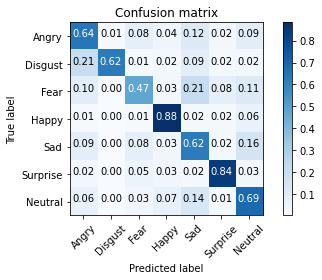

In [ ]:
y_pred = np.rint(weighted_avg_pred)
cm = confusion_matrix(y_true, weighted_avg_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
labels = list(emotion_mapping.values())
title='Confusion matrix'

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
fmt = '0.2f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

plt.savefig('cm.png')
plt.show()